# Stress Test: Symmetry Regularization in Noisy/Difficult Settings

Test if rotational symmetry regularization helps recover ring attractor when:
- Observation model is less expressive
- Higher observation noise
- Baseline xFADS struggles

Compare:
1. **Baseline** (λ=0, no regularization)
2. **Rotational regularization** (λ=1e-1)

In [1]:
# Setup
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import xfads.utils as utils
import xfads.plot_utils as plot_utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

from regularized_ssm import RegularizedSSM, create_rotation_vector_field

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Device: cpu


In [2]:
# Config - STRESS TEST SETTINGS
class Config:
    n_latents = 2
    n_latents_read = 2
    n_hidden_dynamics = 32
    n_hidden_local = 32
    n_hidden_backward = 32
    rank_local = 2
    rank_backward = 2
    p_local_dropout = 0.0
    
    n_samples = 5
    batch_sz = 32
    learning_rate = 1e-2
    max_epochs = 25  # More epochs for difficult problem
    patience = 10
    grad_clip = 1.0
    
    n_trials = 1000
    n_neurons = 100
    n_time_bins = 75
    train_split = 0.8
    
    # STRESS TEST: Higher noise, perturbation
    perturbation_magnitude = 0.3
    observation_noise = 0.3  # INCREASED from 0.1
    process_noise = 1e-2  # Increased from 5e-3
    
    seed = SEED

cfg = Config()
print("⚠️  STRESS TEST SETTINGS:")
print(f"  Neurons: {cfg.n_neurons} (reduced from 100)")
print(f"  Observation noise: {cfg.observation_noise}")
print(f"  Perturbation: {cfg.perturbation_magnitude}")

⚠️  STRESS TEST SETTINGS:
  Neurons: 100 (reduced from 100)
  Observation noise: 0.3
  Perturbation: 0.3


In [3]:
# Load ring attractor
import importlib.util

spec = importlib.util.spec_from_file_location("test_dynamics", "test_dynamics.py")
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

# Create target rotational field
target_rotation_field = create_rotation_vector_field(rotation_speed=0.5)

print("Ring attractor dynamics loaded")
print("Rotational target field created")

Ring attractor dynamics loaded
Rotational target field created


In [4]:
# Generate NOISY data
print("Generating noisy ring attractor data...")

data_gen_dynamics = PerturbedRingAttractorDynamics(
    bin_sz=1e-1,
    lengthscale=0.2,
    perturbation_magnitude=cfg.perturbation_magnitude
).to(device)

C = utils.FanInLinear(cfg.n_latents, cfg.n_neurons, device=device).requires_grad_(False)

# HIGHER NOISE
Q_diag = cfg.process_noise * torch.ones(cfg.n_latents, device=device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=device)
R_diag = cfg.observation_noise * torch.ones(cfg.n_neurons, device=device)
m_0 = torch.zeros(cfg.n_latents, device=device)

z_true = utils.sample_gauss_z(data_gen_dynamics, Q_diag, m_0, Q_0_diag, cfg.n_trials, cfg.n_time_bins)
y = C(z_true) + torch.sqrt(R_diag) * torch.randn((cfg.n_trials, cfg.n_time_bins, cfg.n_neurons), device=device)
y = y.detach()

n_train = int(cfg.train_split * cfg.n_trials)
y_train = y[:n_train]
y_valid = y[n_train:]

print(f"Train: {y_train.shape[0]} trials")
print(f"Valid: {y_valid.shape[0]} trials")
print(f"Observations: {y.shape[2]} neurons (reduced), noise std={np.sqrt(cfg.observation_noise):.3f}")

Generating noisy ring attractor data...
Train: 800 trials
Valid: 200 trials
Observations: 100 neurons (reduced), noise std=0.548


In [5]:
# Create model factory
def create_ssm(lambda_lie):
    H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, cfg.n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg.n_latents, cfg.n_neurons, cfg.n_hidden_local, cfg.n_latents,
        rank=cfg.rank_local, device=device, dropout=cfg.p_local_dropout
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=target_rotation_field if lambda_lie > 0 else None,
        lambda_lie=lambda_lie,
        lambda_curvature=0.0,
        lie_normalize="yang" if lambda_lie > 0 else None,
        device=device
    )
    return ssm

print("Model factory created")

Model factory created


In [6]:
# Training function
def train_model(ssm, y_train, y_valid, name="model"):
    optimizer = torch.optim.Adam(ssm.parameters(), lr=cfg.learning_rate)
    
    best_valid_elbo = float('inf')
    patience_counter = 0
    best_model_state = None
    
    history = defaultdict(list)
    
    print(f"\nTraining {name}...")
    for epoch in range(1, cfg.max_epochs + 1):
        # Train
        ssm.train()
        train_losses = []
        indices = torch.randperm(len(y_train))
        
        for i in range(0, len(y_train), cfg.batch_sz):
            batch_indices = indices[i:i+cfg.batch_sz]
            y_batch = y_train[batch_indices]
            
            optimizer.zero_grad()
            total_loss, _, stats = ssm(y_batch, cfg.n_samples)
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(ssm.parameters(), cfg.grad_clip)
            optimizer.step()
            
            train_losses.append(stats)
        
        train_stats = {k: torch.stack([b[k] for b in train_losses]).mean() for k in train_losses[0].keys()}
        
        # Valid
        ssm.eval()
        with torch.no_grad():
            valid_total_loss, _, valid_stats = ssm(y_valid, cfg.n_samples)
        
        # Track - only scalars
        for k in train_stats.keys():
            if train_stats[k].numel() == 1:
                history[f'train_{k}'].append(train_stats[k].item())
                if valid_stats[k].numel() == 1:
                    history[f'valid_{k}'].append(valid_stats[k].item())
        
        current_valid_elbo = valid_stats['elbo_loss'].item()
        
        if current_valid_elbo < best_valid_elbo:
            best_valid_elbo = current_valid_elbo
            patience_counter = 0
            best_model_state = {k: v.cpu() for k, v in ssm.state_dict().items()}
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            lie_loss = valid_stats.get('lie_loss', torch.tensor(0.0))
            lie_str = f", Lie = {lie_loss.item():.3e}" if lie_loss.numel() == 1 else ""
            print(f"  Epoch {epoch}: Valid ELBO = {current_valid_elbo:.3f}{lie_str}, Patience = {patience_counter}/{cfg.patience}")
        
        if patience_counter >= cfg.patience:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    if best_model_state is not None:
        ssm.load_state_dict(best_model_state)
        print(f"  ✅ Best ELBO: {best_valid_elbo:.6f}")
    
    return history, best_valid_elbo

print("Training function ready")

Training function ready


In [7]:
# Train BASELINE (no regularization)
print("=" * 60)
print("BASELINE: No regularization (λ=0)")
print("=" * 60)

torch.manual_seed(SEED)
np.random.seed(SEED)

ssm_baseline = create_ssm(lambda_lie=0.0)
history_baseline, elbo_baseline = train_model(ssm_baseline, y_train, y_valid, "Baseline")

BASELINE: No regularization (λ=0)

Training Baseline...
  Epoch 5: Valid ELBO = 6397.875, Lie = 0.000e+00, Patience = 1/10
  Epoch 10: Valid ELBO = 6315.545, Lie = 0.000e+00, Patience = 1/10
  Epoch 15: Valid ELBO = 6319.078, Lie = 0.000e+00, Patience = 3/10
  Epoch 20: Valid ELBO = 6282.151, Lie = 0.000e+00, Patience = 0/10
  Epoch 25: Valid ELBO = 6279.402, Lie = 0.000e+00, Patience = 1/10
  ✅ Best ELBO: 6275.641113


In [14]:
# Train WITH ROTATIONAL REGULARIZATION
print("\n" + "=" * 60)
print("REGULARIZED: Rotational symmetry (λ=1e-1)")
print("=" * 60)

torch.manual_seed(SEED)
np.random.seed(SEED)

ssm_regularized = create_ssm(lambda_lie=1e0)
history_regularized, elbo_regularized = train_model(ssm_regularized, y_train, y_valid, "Regularized")


REGULARIZED: Rotational symmetry (λ=1e-1)

Training Regularized...
  Epoch 5: Valid ELBO = 15313.144, Lie = 4.439e+05, Patience = 2/10
  Epoch 10: Valid ELBO = 11053.416, Lie = 1.654e+03, Patience = 7/10


KeyboardInterrupt: 

In [12]:
# Compare results
print("\n" + "=" * 60)
print("COMPARISON")
print("=" * 60)
print(f"Baseline ELBO:     {elbo_baseline:.3f}")
print(f"Regularized ELBO:  {elbo_regularized:.3f}")
print(f"Improvement:       {elbo_baseline - elbo_regularized:.3f}")
if elbo_regularized < elbo_baseline:
    print("✅ Regularization HELPS in this difficult setting!")
else:
    print("❌ Regularization did not improve (may need to adjust λ)")


COMPARISON
Baseline ELBO:     6275.641
Regularized ELBO:  10119.412
Improvement:       -3843.771
❌ Regularization did not improve (may need to adjust λ)


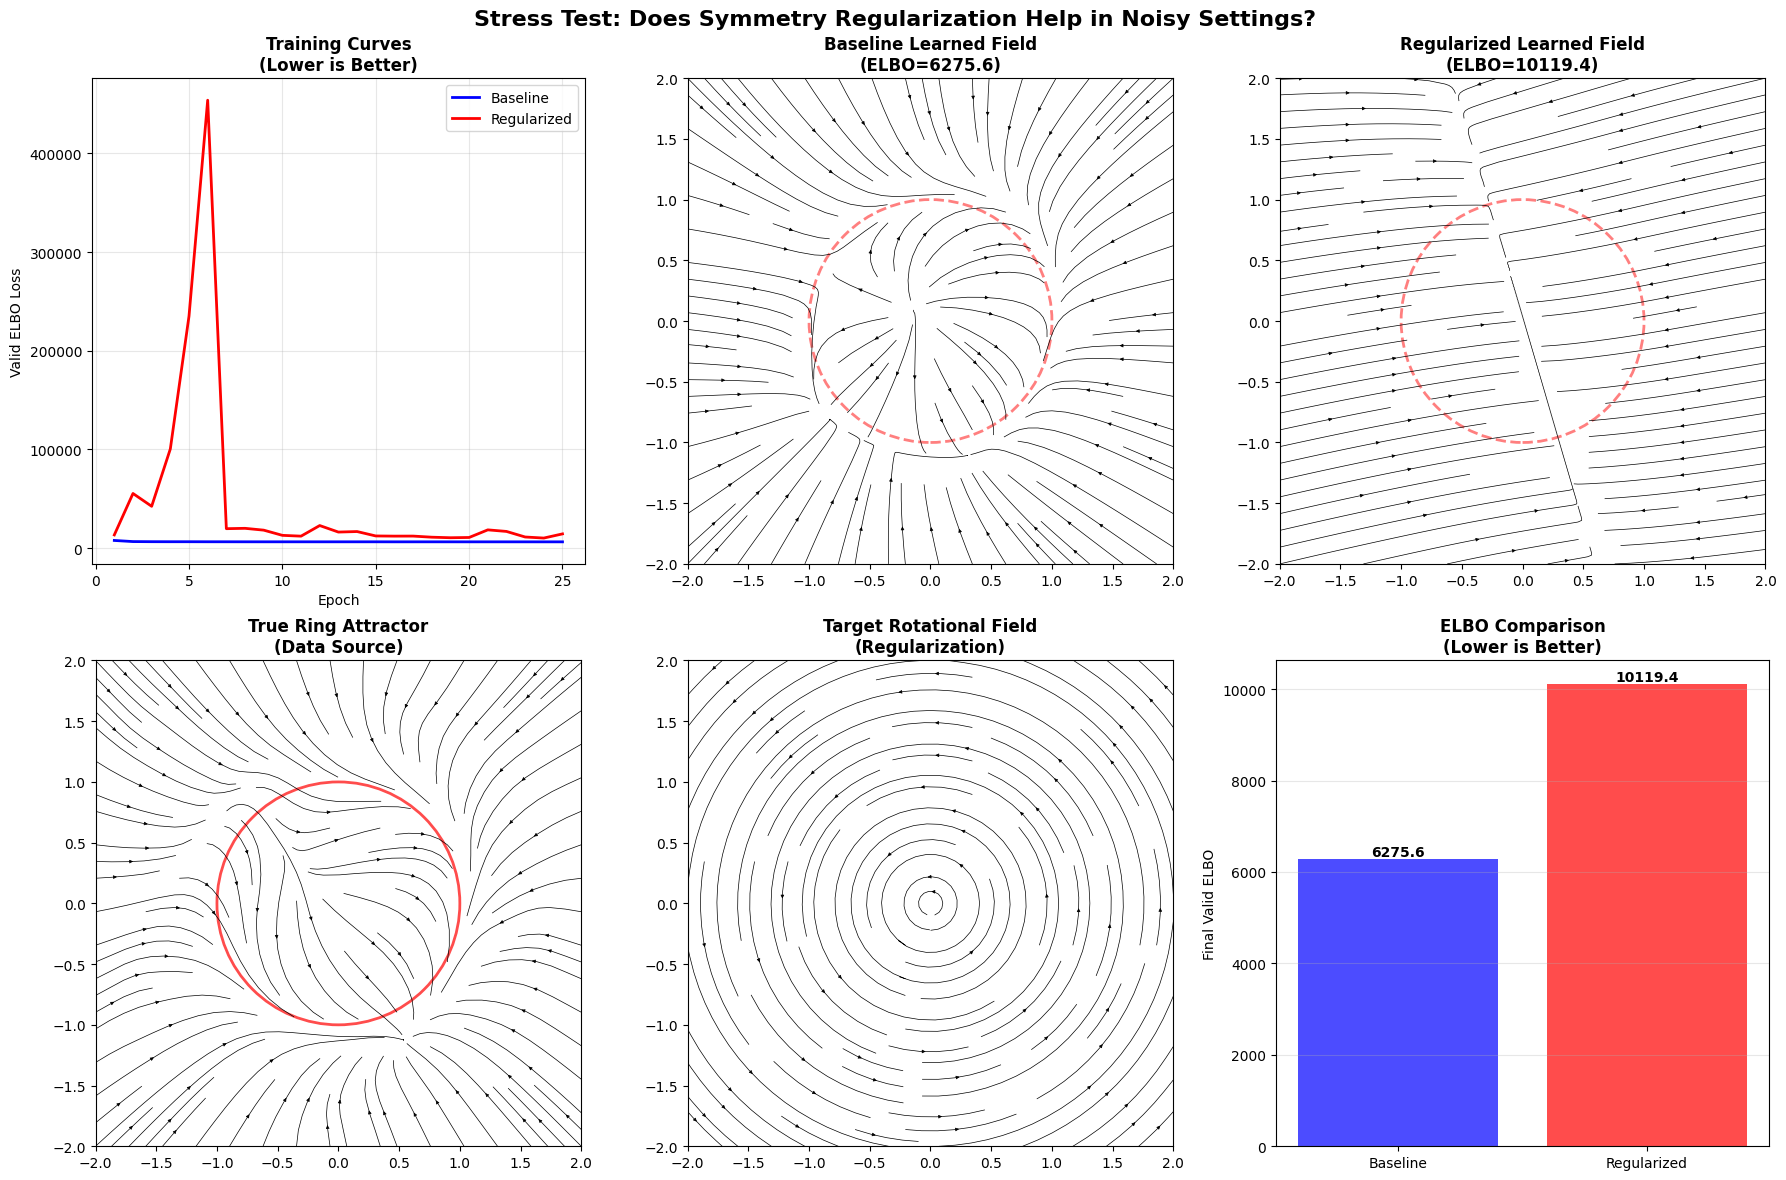


Saved: stress_test_results.png


In [13]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training curves
ax = axes[0, 0]
epochs_b = range(1, len(history_baseline['train_elbo_loss']) + 1)
epochs_r = range(1, len(history_regularized['train_elbo_loss']) + 1)
ax.plot(epochs_b, history_baseline['valid_elbo_loss'], 'b-', label='Baseline', linewidth=2)
ax.plot(epochs_r, history_regularized['valid_elbo_loss'], 'r-', label='Regularized', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Valid ELBO Loss')
ax.set_title('Training Curves\n(Lower is Better)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Baseline vector field
ax = axes[0, 1]
ssm_baseline.eval()
plot_utils.plot_two_d_vector_field(ssm_baseline.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Baseline Learned Field\n(ELBO={elbo_baseline:.1f})', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Regularized vector field
ax = axes[0, 2]
ssm_regularized.eval()
plot_utils.plot_two_d_vector_field(ssm_regularized.dynamics_mod.mean_fn, ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.add_patch(circle)
ax.set_title(f'Regularized Learned Field\n(ELBO={elbo_regularized:.1f})', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# True ring attractor
ax = axes[1, 0]
plot_utils.plot_two_d_vector_field(data_gen_dynamics.to('cpu'), ax, min_xy=-2, max_xy=2)
circle = plt.Circle((0, 0), 1.0, fill=False, color='red', linewidth=2, alpha=0.7)
ax.add_patch(circle)
ax.set_title('True Ring Attractor\n(Data Source)', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# Target rotational field
ax = axes[1, 1]
dt = 1e-2
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_rotation_field(x), ax, min_xy=-2, max_xy=2
)
ax.set_title('Target Rotational Field\n(Regularization)', fontweight='bold')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')

# ELBO comparison bar chart
ax = axes[1, 2]
bars = ax.bar(['Baseline', 'Regularized'], [elbo_baseline, elbo_regularized], 
              color=['blue', 'red'], alpha=0.7)
ax.set_ylabel('Final Valid ELBO')
ax.set_title('ELBO Comparison\n(Lower is Better)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Stress Test: Does Symmetry Regularization Help in Noisy Settings?', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('stress_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: stress_test_results.png")